In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch import autograd

In [22]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler1 = StandardScaler()
scaler2 = MaxAbsScaler()

data_standard = scaler1.fit_transform(data)
# data_standard = scaler2.fit_transform(data_standard)
#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

In [23]:
print(np.max(data_standard))
print(np.min(data_standard))

3.37475991493086
-3.4300192947559176


# Neural Network

In [24]:
x_all = Variable(torch.from_numpy(data_standard))
y_all = Variable(torch.from_numpy(data_PE))

In [25]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
y_ts=y_ts.reshape(n_train,1)
y_test_ts = y_test_ts.reshape(n_test,1)
x=Variable(x_ts)

In [26]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()


model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [27]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(3000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    # updating parameters
    optimizer.step()

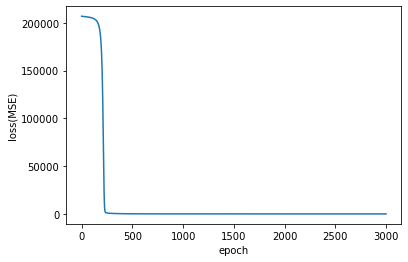

In [28]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.9283154997622493
MSE is 20.636391175037247


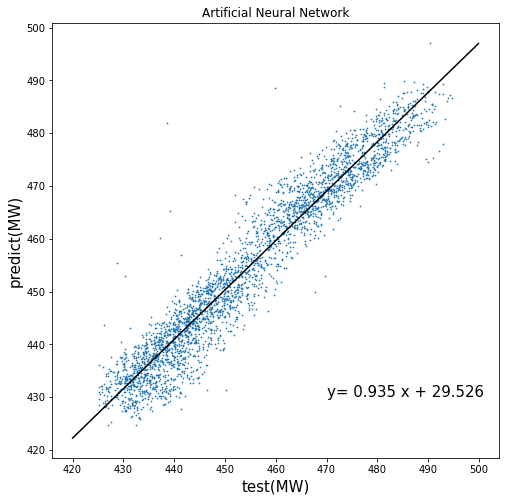

In [29]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Train a GAN model

In [30]:
# define the discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(4, 18), 
            nn.LeakyReLU(0.2),  
            nn.Linear(18, 18),  
            nn.LeakyReLU(0.2),
            nn.Linear(18, 1),
            nn.Sigmoid()  
            
        )
 
    def forward(self, x):
        x = self.dis(x)
        return x

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(3, 18),  
            nn.ReLU(True),  
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 4)
#             nn.Tanh()  
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x




# MIA(Momentum Iterative Attack)

In [31]:
def MIA_attack(x_test_ts, y_test_ts, level):
    nums_steps = 10
    alpha = level/nums_steps
    x_adv_ts = Variable(x_test_ts,requires_grad=True)
    zero_gradients(x_adv_ts)
    g = 0
    decay_factor = 0.5
    
    for i in range(nums_steps):
        y_test_model=model(x_adv_ts)
        loss = loss_func(y_test_ts,y_test_model)
        loss.backward()
        grad = x_adv_ts.grad.data
        normed_grad = torch.zeros_like(grad)
        num_samples = grad.shape[0]
        for j in range(num_samples):
            normed_grad[j] = grad[j]/torch.norm(grad[j], p = 1)
            
        g = decay_factor*g + normed_grad
        signed_grad = torch.sign(g)
        
        x_adv_ts = x_adv_ts + alpha*signed_grad
#         x_adv_ts = torch.clamp(x_adv_ts, np.min(data_standard),np.max(data_standard))
        y_adv_ts = model(x_adv_ts)
        
        x_adv_ts = Variable(x_adv_ts,requires_grad=True)
        zero_gradients(x_adv_ts)
    return x_adv_ts, y_adv_ts
  



In [32]:
# levels = np.arange(start=0, stop=0.22, step=0.03)

levels = np.arange(start=0, stop=0.22, step=0.03)

#y_ts=y_ts.reshape(3158,1)

train_scores = []
test_scores = []
test_MAPE = []

pert_level = []

for level in levels:
    x_adv_ts, y_adv_ts = MIA_attack(x_test_ts,y_test_ts,level)
    y_p1 = y_adv_ts.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores.append(r)
    
    test_error = mean_absolute_percentage_error(y_test,y_p1)*2500
    test_MAPE.append(test_error)
    test_MAPE
    
    pert = mean_absolute_percentage_error(x_test_ts,x_adv_ts.detach().numpy())/10
    pert_level.append(pert*100)
    

[1948.18472698 2296.74509279 2644.35471212 2991.08799777 3337.50488894
 3683.08069849 4027.76694327 4371.72334352]


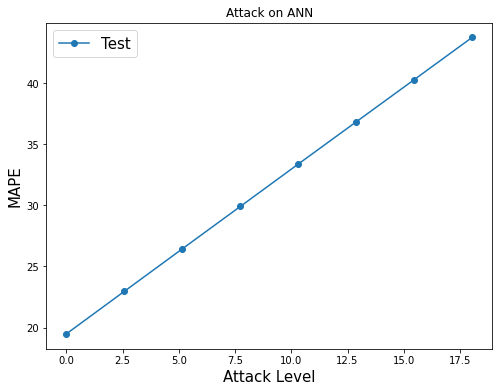

In [33]:
plt.figure(figsize=(8,6))
# plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(pert_level, np.array(test_MAPE), label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Attack on ANN")
print(np.array(test_MAPE)*100)

# GAN based denoising

# PCA defense

# Autoencoder

In [34]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(torch.nn.Linear(4, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 3))
        self.decoder = nn.Sequential(torch.nn.Linear(3, 8),
                                     torch.nn.ReLU(),
                                     torch.nn.Linear(8, 8),
                                     torch.nn.Tanh(),
                                     torch.nn.Linear(8, 4),
                                     torch.nn.Tanh())
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
                                     
model_ae = autoencoder().double()

# load saved model

In [35]:
class Model_pca(torch.nn.Module):
    def __init__(self):
        super(Model_ReducedDim,self).__init__()
        self.linear1 = torch.nn.Linear(3,12) 
        self.linear2 = torch.nn.Linear(12,8)
        self.predict = torch.nn.Linear(8,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out

In [36]:
# model_p = torch.load('model_pca')
model_1 = torch.load('model_ae')
model_2 = torch.load('model_ae_defense')

model_GAN = torch.load('G')

In [37]:
testAE_new_scores = []
testGAN_new_scores = []

testAE_new_MAPE = []
testGAN_new_MAPE = []



lr = 1e2
loss_func = torch.nn.MSELoss()
dim_noise = 3
num_iter = 1500

for level in levels:


    x_adv_ts, y_adv_ts = MIA_attack(x_all,y_all,level)
    
    #     autoencoder
    x_pred = model_1(x_adv_ts)[0]
    y_p1 = model_2(x_pred)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_all,y_p1)
    testAE_new_scores.append(r)
    
    testAE_new_error = mean_absolute_percentage_error(y_all,y_p1)*2000
    testAE_new_MAPE.append(testAE_new_error)
    

    
#     GAN

    z = Variable(torch.randn(y_all.shape[0], dim_noise))  
    # Generate random noise
    z.requires_grad = True
    for i in range(num_iter):
        z.retain_grad()
        x_gen = model_GAN(z)

        loss = loss_func(x_adv_ts,x_gen) 
        loss.backward(retain_graph=True)  
        z = z-lr*z.grad
        
    y_gen_pred = model(x_gen.double())
#     r2 = r2_score(y_test_ts.detach().numpy(),y_gen_pred.detach().numpy())
    r2 = r2_score(y_all.detach().numpy(),y_gen_pred.detach().numpy())
    testGAN_new_scores.append(r2)
    
    testGAN_new_error = mean_absolute_percentage_error(y_all.detach().numpy(),y_gen_pred.detach().numpy())*2000
    testGAN_new_MAPE.append(testGAN_new_error)

F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([9568, 1])) that is different to the input size (torch.Size([9568])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

In [38]:
model_p = torch.load('model_pca')
pca = PCA(n_components=3)

testPCA_new_scores = []
testPCA_new_MAPE = []


for level in levels:
    x_adv_ts, y_adv_ts = MIA_attack(x_test_ts,y_test_ts,level)
    x_adv_ts  = x_adv_ts.detach().numpy()
    
    x_te_pca = pca.fit_transform(x_adv_ts)
    x_te_pca=torch.from_numpy(x_te_pca)
    y_p1 = model_p(x_te_pca)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    testPCA_new_scores.append(r)
    
    testPCA_new_error = mean_absolute_percentage_error(y_test,y_p1)*2000
    testPCA_new_MAPE.append(testPCA_new_error)


Text(0.5, 1.0, 'Momentum Iterative Attack')

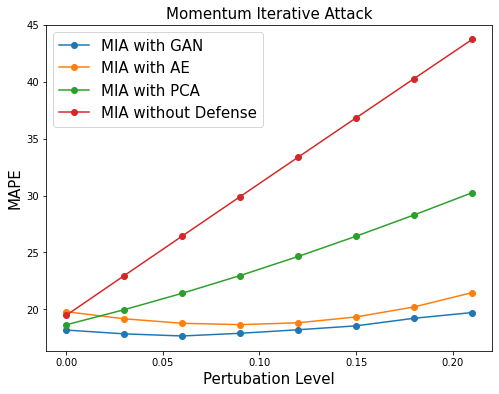

In [39]:

plt.figure(figsize=(8,6))
# plt.plot(levels, testGAN_new_scores, label="FGSM with newGAN",marker='o');
# plt.plot(levels, testAE_new_scores, label="FGSM with newAE",marker='o');
# plt.plot(levels, testPCA_new_scores, label="FGSM with newPCA",marker='o');

plt.plot(levels, np.array(testGAN_new_MAPE), label="MIA with GAN",marker='o');
plt.plot(levels, np.array(testAE_new_MAPE), label="MIA with AE",marker='o');
plt.plot(levels, np.array(testPCA_new_MAPE), label="MIA with PCA",marker='o');

plt.plot(levels, np.array(test_MAPE), label="MIA without Defense",marker='o');
plt.xlabel("Pertubation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Momentum Iterative Attack",fontsize=15)
# plt.title("GAN-based denoising")

In [40]:
print(levels)
print(testGAN_new_MAPE)
print(testAE_new_MAPE)
print(testPCA_new_MAPE)
print(test_MAPE)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21]
[18.18540280293648, 17.851707342284644, 17.665006315254082, 17.90091627681089, 18.211157406370475, 18.555926005595932, 19.22053270670472, 19.72208801006312]
[19.797934667931866, 19.17611597631361, 18.780051674453826, 18.65993356327779, 18.82478598160433, 19.336025276538063, 20.21785897728912, 21.473304957604892]
[18.64950563378664, 19.97356365225568, 21.415227309825603, 22.975931697662563, 24.64992314714434, 26.430682799454303, 28.300716009484024, 30.248346117360068]
[19.481847269809908, 22.967450927855698, 26.443547121212074, 29.91087997773456, 33.375048889440386, 36.830806984933915, 40.27766943271412, 43.717233435205465]
